# Лабораторная работа 3 

In [ ]:
from dataclasses import dataclass
import numpy as np
import scipy
import matplotlib.pyplot as plt

## 1.Содержательная постановка задачи.
Представим ракету в виде упрощенной модели , как представленно на рисунке ниже . Масса ракеты при этом скаладывается из массы констрункии ракеты $m_p$ и массы выбрасываемых газов $m_g$ . В определенный рассматриваемый момент времени ракета движется со скоростью $V_p$ , отбрасываемые газы движутся со скоростью $V_g$ .

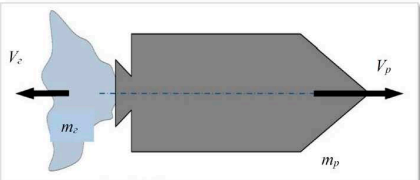

# 2.Концептуальная постановка задачи 
1. Будем рассматривать движение ракеты в безвоздушном пространстве .
2. Продукты сгорания покидают кормовые сопла ракеты в системе координат , в которой ракета неподвижна . 
3. Считаем ракету неподвижной точкой 

# 3.Математическая постановка задачи 
* Уравнение Циалковского для реактивного движения * 
За время $dt$ часть топлива выгорает , так что суммарная летящая масса изменяется на $dm$ (при этом $dm < 0 $ ) . Из закона сохранения импульса следует , что : 
$m(t)*V_p(t) = m(t+dt)*V_p(t+dt)-dm(V_p(t +\epsilon*dt) - V_g)$,$0<\epsilon<1$.
где: 
1. m = $m_p+m_g$ - масса собоственно ракеты и топлива 
2. $m_p$ - массса ракеты 
3. $m_g$ - масса топлива 
4. $V_p$ - скорость ракеты 
5. $V_g$ - скорость истекания газов 
6. $V_p(t+\epsilon*dt)-V_g$ - средняя за промежуток $dt$ скорость истекающих газов 
Отсюда получаем уравнение : 

$\frac{m*dV_p(t)}{(dt)} = - \frac{V_gdm(t)}{dt}$.

Данное уравнение необходимо решить при t > 0 . Считаем , что 

$ V = V_0 , m = m_0 $ при t = 0 .

Полученное уравнение переписываем в удобной для интегрирования форме : 

$\frac{dV_p}{dt} = -\frac{V_gdm}{mdt} = -\frac{V_gdln(m)}{dt}$

Откуда 

$V_p(t) = V_0 + V_gln\frac{m_0}{m(t)}$

$m_0 = m_p + m_g + m_n$ , где $m_n$ - масса полезной нагрузки 

Так как наша ракета начинает свой полет с Земли , то при старте $V_0$ = 0 , после того , как ракета поднимается на определенную высоту и её первая  пусковая ступень  отсоединяется , ракета продолжает свое движение с той же скоростью . После отсоединения первой пусковой ступени , начанает работать вторая пусковая ступень и для нее $V_0$ становится равной уже набранной скорости ракеты . 

Рассмотрим предельное значение скорости ракеты , если ее начальная скорость равна нулю , т.е на старте $V_g = 0$ 

Пусть всё топливо уже израсходовано : $ m(t) = m_p + m_n$ 

Тогда  

$V_p(t) = V_gln(1+\frac{m_0}{m_p+m_n})$

Введем коэффициент 

$\alpha  = \frac{m_n}{m_0 - m_p}$

Характерезующий отношение структурной массы ракеты и массы топлива .

Легко увидеть , что при фиксированных других параметрах конечная скорость тем выше , чем меньше полезная нагрузка . 

После сгорания всего топлива итоговая скорость есть 

$V_p = V_gln(\frac{1}{\alpha})$



Text(0, 0.5, 'Максимальная скорость ракеты, м/с')

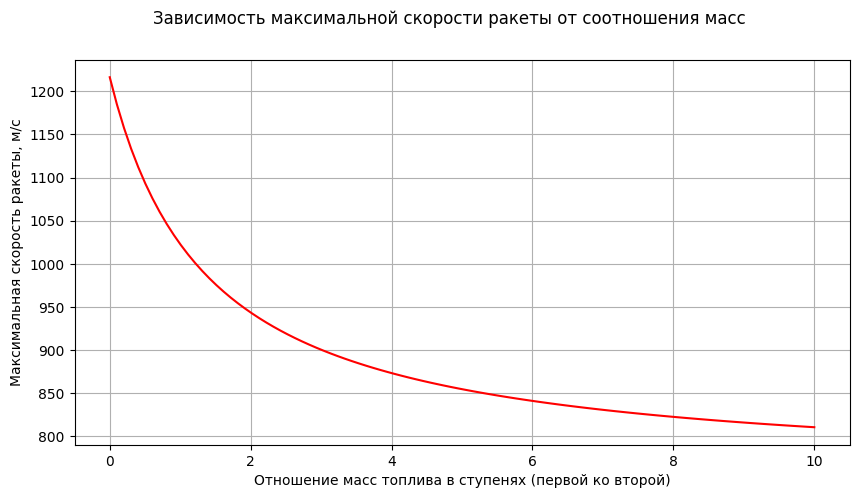

In [48]:

@dataclass
class TaskConditions:
    m_n: float
    m_f: float
    m_ps: list[float]
    V_g: float


def max_velocity_2p(
    task_conditions: TaskConditions,
    alpha: float
) -> float:
    m_fuel = task_conditions.m_f
    m_n = task_conditions.m_n
    m_ps = task_conditions.m_ps
    V_g = task_conditions.V_g
    m_g_1 = alpha * m_fuel / (1 + alpha)
    m_g_2 = m_fuel / (1 + alpha)
    m_gs = [m_g_1, m_g_2]
    m = m_n + m_fuel + sum(m_ps)
    V0 = 0
    for m_g, m_p in zip(m_gs, m_ps):
        V0 = V0 + V_g*np.log(m/(m - m_g))
        m = m - m_g - m_p
    return V0


def velocity_3p(
    task_conditions: TaskConditions,
    alpha_vals: list[float],
    fuel_burnouts: list[float],
    evals: int
) -> tuple[list[list[float]], list[list[float]]]:
    m_fuel = task_conditions.m_f
    m_n = task_conditions.m_n
    m_ps = task_conditions.m_ps
    V_g = task_conditions.V_g
    alpha_sum = sum(alpha_vals)
    m_gs = [alpha * m_fuel / alpha_sum for alpha in alpha_vals]
    m = m_n + m_fuel + sum(m_ps)
    part_id = 0
    V0 = 0
    velocity_vals = [[]]
    times = [[]]
    t0 = 0
    time_stamps = np.linspace(0, fuel_burnouts[-1], evals)
    t_f = fuel_burnouts[part_id]
    for t in time_stamps:
        if t <= t_f:
            velocity_vals[-1].append(V0 + V_g*np.log(m/(m - (t-t0)*m_gs[part_id]/(t_f-t0))))
            times[-1].append(t)
        else:
            V0 = V0 + V_g*np.log(m/(m - m_gs[part_id]))
            m = m - m_gs[part_id] - m_ps[part_id]
            part_id += 1
            t0 = t_f
            t_f = fuel_burnouts[part_id]
            velocity_vals.append([])
            times.append([])
    return times, velocity_vals


task_conditions = TaskConditions(800, 1000, [1500, 1200], 3000)
alpha_vals = np.linspace(0, 10, 100)
velocity_vals = []
for alpha in alpha_vals:
    velocity_vals.append(max_velocity_2p(task_conditions, alpha))

fig = plt.figure()
fig.suptitle('Зависимость максимальной скорости ракеты от соотношения масс')
fig.set_size_inches((10,5))
ax = fig.add_subplot()
ax.grid(True)
ax.plot(alpha_vals, velocity_vals, color='red')
ax.set_xlabel('Отношение масс топлива в ступенях (первой ко второй)')
ax.set_ylabel('Максимальная скорость ракеты, м/с')

### Задание 2

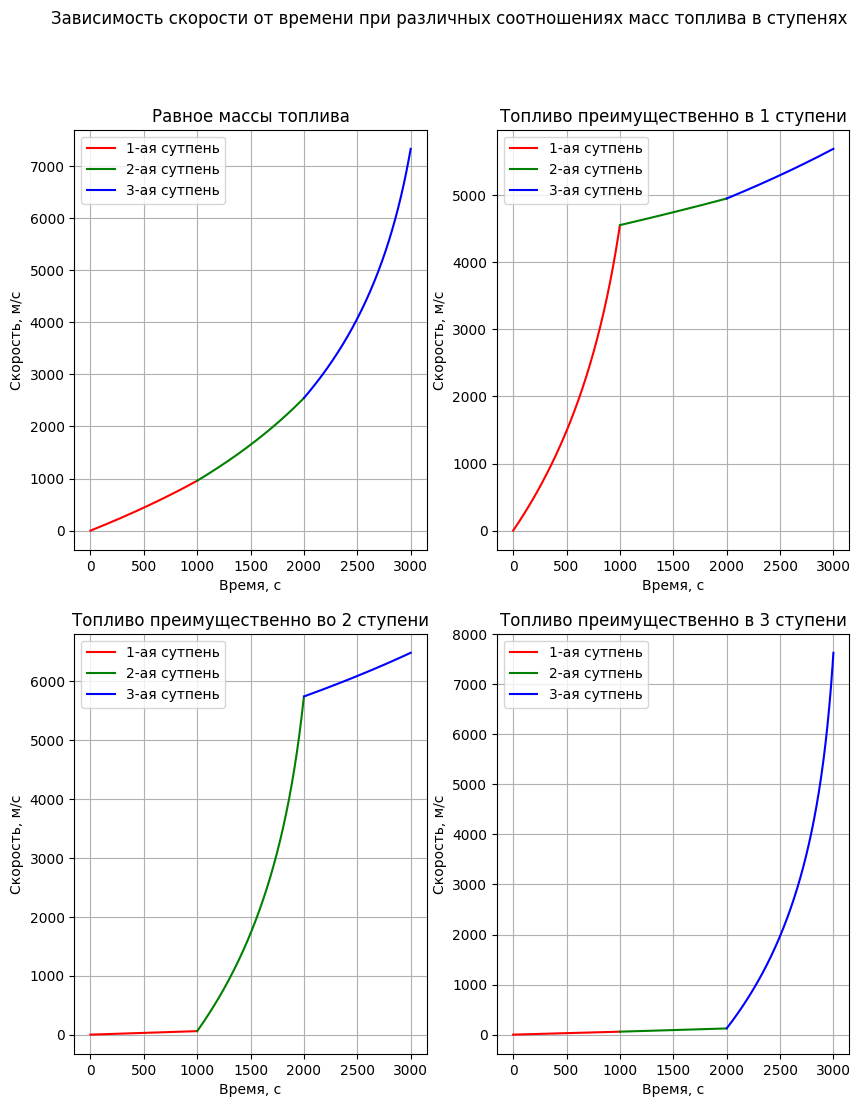

In [56]:
task_conditions = TaskConditions(800, 20000, [1500, 1200, 900], 3000)
fig = plt.figure()
fig.set_size_inches((10,12))
fig.suptitle('Зависимость скорости от времени при различных соотношениях масс топлива в ступенях')
alphas = [[1,1,1], [40, 1, 1], [1, 40, 1], [1, 1, 40]]
ax_titles = ['Равное массы топлива',
             'Топливо преимущественно в 1 ступени',
             'Топливо преимущественно во 2 ступени',
             'Топливо преимущественно в 3 ступени']
ax_id = 1
for alpha_vals, ax_title in zip(alphas, ax_titles):
    ax = fig.add_subplot(2, 2, ax_id)
    ax.grid(True)
    ax.set_title(ax_title)
    ax.set_xlabel('Время, с')
    ax.set_ylabel('Скорость, м/с')
    fuel_burnouts = [1000, 2000, 3000]
    evals = 3000
    times, velocities = velocity_3p(task_conditions, alpha_vals, fuel_burnouts, evals)
    colors = ['red', 'green', 'blue']
    i = 1
    for time_vals, velocity_vals, color in zip(times, velocities, colors):
        ax.plot(time_vals, velocity_vals, color=color, label=f'{i}-ая сутпень')
        i += 1
    ax.legend()
    ax_id += 1